In [6]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib


In [7]:
import sklearn
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor

from scipy.cluster.vq import kmeans, vq, whiten
from scipy.spatial.distance import cdist
import numpy as np
from datetime import datetime


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
os.chdir("/content/gdrive/My Drive/EDX Data Science for Construction, Architecture and Engineering/3 - Construction - Pandas Fundamentals/meter_data/")

In [5]:
df_prediction_data = pd.read_csv("UnivClass_Ciara.csv", parse_dates=True, index_col='timestamp')

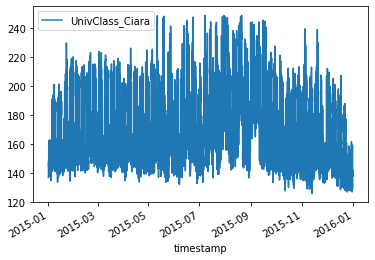

In [8]:
df_prediction_data.plot()

In [9]:
os.chdir("/content/gdrive/My Drive/EDX Data Science for Construction, Architecture and Engineering/3 - Construction - Pandas Fundamentals/weather_data/")
weather_data = pd.read_csv("weather2.csv", index_col='timestamp', parse_dates=True)

In [10]:
weather_hourly = weather_data.resample("H").mean()
weather_hourly_nooutlier = weather_hourly[weather_hourly > -40]
weather_hourly_nooutlier_nogaps = weather_hourly_nooutlier.fillna(method='ffill')

In [11]:
temperature = weather_hourly_nooutlier_nogaps["TemperatureC"]

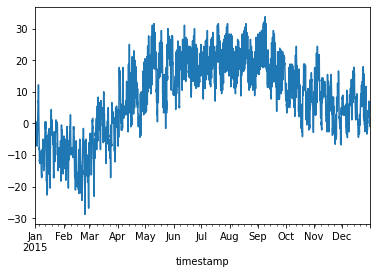

In [12]:
temperature.plot()

In [13]:
training_months = [4,5,6]
test_months = [7]

We can divide the data set by using the `datetime index` of the data frame and a function known as `.isin` to extract the months for the model

In [14]:
trainingdata = df_prediction_data[df_prediction_data.index.month.isin(training_months)]
testdata = df_prediction_data[df_prediction_data.index.month.isin(test_months)]


In [15]:
trainingdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2184 entries, 2015-04-01 00:00:00 to 2015-06-30 23:00:00
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   UnivClass_Ciara  2184 non-null   float64
dtypes: float64(1)
memory usage: 34.1 KB


In [16]:
testdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2015-07-01 00:00:00 to 2015-07-31 23:00:00
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   UnivClass_Ciara  744 non-null    float64
dtypes: float64(1)
memory usage: 11.6 KB


In [17]:
train_features = pd.concat([pd.get_dummies(trainingdata.index.hour), 
                                     pd.get_dummies(trainingdata.index.dayofweek), 
                                     pd.DataFrame(temperature[temperature.index.month.isin(training_months)].values)], axis=1).dropna()


In [18]:
train_features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,0,1,2,3,4,5,6,0
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,-5.5
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,-6.1
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,-7.2
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,-6.6
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,-7.2


In [19]:
model = KNeighborsRegressor().fit(np.array(train_features), np.array(trainingdata.values));


In [20]:
test_features = np.array(pd.concat([pd.get_dummies(testdata.index.hour),
                                    pd.get_dummies(testdata.index.dayofweek),
                                    pd.DataFrame(temperature[temperature.index.month.isin(test_months)].values)], axis=1).dropna())

In [21]:
predictions = model.predict(test_features)

In [22]:
predicted_vs_actual = pd.concat([testdata, pd.DataFrame(predictions, index=testdata.index)], axis=1)

In [23]:
predicted_vs_actual.columns = ["Actual", "Predicted"]

In [24]:
predicted_vs_actual.head()

,Actual,Predicted
timestamp,,
2015-07-01 00:00:00,151.525002,171.324998
2015-07-01 01:00:00,152.575005,185.139999
2015-07-01 02:00:00,149.725006,170.325003
2015-07-01 03:00:00,151.125000,187.010001
2015-07-01 04:00:00,146.000000,171.700002


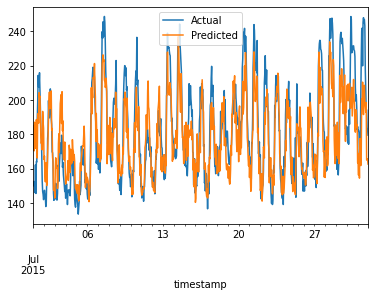

In [25]:
predicted_vs_actual.plot()

In [26]:
trainingdata.columns = ["Actual"]

In [27]:
predicted_vs_actual_plus_training = pd.concat([trainingdata, predicted_vs_actual], sort=True)

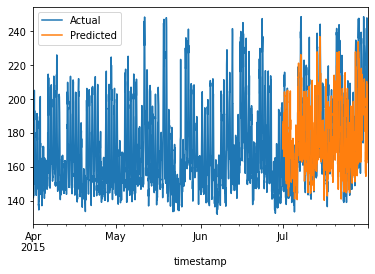

In [28]:
predicted_vs_actual_plus_training.plot()

In [29]:
# Calculate the absolute errors
errors = abs(predicted_vs_actual['Predicted'] - predicted_vs_actual['Actual'])
# Calculate mean absolute percentage error (MAPE) and add to list
MAPE = 100 * np.mean((errors / predicted_vs_actual['Actual']))

In [30]:
MAPE

6.881150749239448